# Materials associated with the paper: 

Cao, W., Zahirovic, S., Flament, N., Williams, S., Golonka, J., and Müller, R. D., 2017: Improving global paleogeography since the late Paleozoic using paleobiology, Biogeosciences, 14, 5425-5439. https://doi.org/10.5194/bg-14-5425-2017.

### This Jupyter notebook is used to produce the figure in the supplement of the above paper.

The code in this notebook is written in Python 2.7. It utilizes standard scientific Python modules as well as modules from the open source pygplates which provides a Python API to the open source GPlates software (https://www.gplates.org/). Here, the source code has been modified to Python 3.7 by Behnam Sadeghi.

## Import Python modules

In [1]:
import pygplates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import StringIO
%matplotlib inline

## Read the data and models

In [2]:
rotation_model=pygplates.RotationModel('../Data/Fig_supplement/Seton_etal_ESR2012_2012.1.rot')
rotation_model = pygplates.RotationModel(pygplates.FeatureCollection())

paleoshoreline_filename = '../Data/Fig_supplement/Global_Paleoshorelines_Golonka.shp'
psl_features = pygplates.FeatureCollection(paleoshoreline_filename)

marine_fossil_filename = '../Data/Fig_supplement/Paleodb_marine_llyeo1.gpmlz'
marine_fossil_features = pygplates.FeatureCollection(marine_fossil_filename)


## Define the function

In [3]:
# This function not used
def SortPolygons():
    
    polygon_infos=[]
    for polygon_feature in features:
        for polygon_geometry in polygon_feature.get_all_geometries():
            if polygon_geometry.get_area()>1e-8:
                polygon_infos.append((polygon_feature, polygon_geometry))

    polygon_infos.sort(key = lambda polygon_info: polygon_info[1].get_area(), reverse=True)
    
    sorted_polygons = pygplates.Feature()
    geometry_list = []
    for polygon_info in polygon_infos:
        geometry_list.append(polygon_info[1])  

# Function that does all the work
def point_in_or_near_polygon(point_features,polygon_features):
    
    polydist = []
    inpoly = []
    
    for point_feature in point_features:

        min_distance_to_polygon_edge = np.pi/2 
        within_polygon = -1
                
        # look for distance to nearest boundary - only happens if the point does NOT
        # satisfy the criteria (ie inside if we want inside, or outside if we want outside)
        for polygon_feature in polygon_features:
            for geometry in polygon_feature.get_reconstructed_geometry():                
                
                min_distance_to_feature = pygplates.GeometryOnSphere.distance(
                    point_feature.get_reconstructed_geometry(),
                    geometry,
                    min_distance_to_polygon_edge)
            
                if min_distance_to_feature is not None:
                    min_distance_to_polygon_edge = min_distance_to_feature
                    
                if polygon_feature.get_reconstructed_geometry().is_point_in_polygon(point_feature.get_reconstructed_geometry()):
                    within_polygon = 1

        polydist.append(min_distance_to_polygon_edge) 
        inpoly.append(within_polygon)

    return (polydist,inpoly)


## Reconstruct the data points back in time

In [4]:
for psl in psl_features:
    print (psl.get_geometry())

import time
# As a test, run analysis for one time step
polygons = []
pygplates.reconstruct(psl_features,rotation_model,polygons,30)

mpoints = []
pygplates.reconstruct(marine_fossil_features,rotation_model,mpoints,30)

mpolydist,minpoly = point_in_or_near_polygon(mpoints,polygons)
#print time.time()

#plt.hist(np.array(minpoly)*np.array(mpolydist)*pygplates.Earth.mean_radius_in_kms,
#         np.arange(-1000,1001,50))
#plt.show()

None
None
None
None
None
None
None
None
None
None
None


## Run analysis for all times

In [5]:
time_list = []
mpolydist_list = []
minpoly_list = []

for f in psl_features:
    
    #time = np.median(f.get_valid_time())
    time = f.get_shapefile_attribute('ReconAge')
    print (time)
    time_list.append(time)
    
    polygons = []
    pygplates.reconstruct(psl_features,rotation_model,polygons,time)
    
    mpoints = []
    pygplates.reconstruct(marine_fossil_features,rotation_model,mpoints,time)
    
    mpolydist,minpoly = point_in_or_near_polygon(mpoints,polygons)
    mpolydist_list.append(mpolydist)
    minpoly_list.append(minpoly)


6.0
14.0
22.0
33.0
45.0
53.0
76.0
90.0
105.0
126.0
140.0


## Plot the results

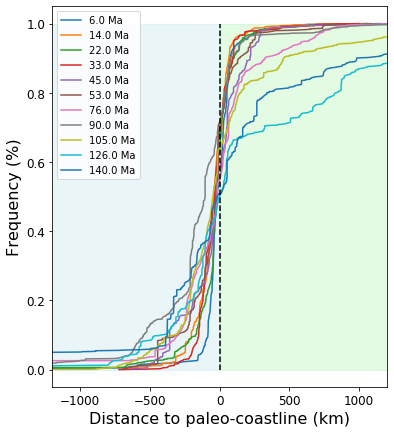

In [6]:
# Cumulative frequency for the distance of the point to the polygon boundary
# where:
#   - for marine, negative distance is success (ie outside paleoshoreline polygon)
#   - for terrestrial, positive distance is success (ie inside paleoshoreline polygon)

plt.figure(figsize=(6,7))

plt.subplot(111)
for time,polydist,inpoly in zip(time_list,mpolydist_list,minpoly_list):
    
    dst = np.asarray(polydist)*np.asarray(inpoly)
    dst = np.sort(dst)
    xtmp = np.linspace(0,1,len(polydist))
    plt.plot(dst*pygplates.Earth.mean_radius_in_kms,xtmp,label='%0.1f Ma' % time)

plt.fill_between([-10000,0],[0,0],[1,1],color='lightblue',alpha=0.25)
plt.fill_between([0,10000],[0,0],[1,1],color='lightgreen',alpha=0.25)
plt.plot([0,0],[0,1],'k--')
plt.xlim(-1200,1200)
plt.xticks(size=12)
plt.xlabel('Distance to paleo-coastline (km)', size=16)
plt.ylabel('Frequency (%)', size=16)
plt.yticks(size=12)
#plt.title('marine')
plt.legend(loc='upper left')

plt.savefig('Output/Fig_supplement.pdf')
plt.show()
